<a href="https://colab.research.google.com/github/annasvenbro/etudesnordiques/blob/main/Test_API_SRU_Sudoc_suedois.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Test de l'API SRU du Sudoc pour la présence des fonds en langues nordiques dans les RCR du réseau

**On se limitera pour ce test au suédois** (code langue "swe").

##Import des paquets nécessaires

In [ ]:
import requests as rq
import xml.etree.ElementTree as et
import pandas as pd
import numpy as np
import json
import json.decoder

## On commence avec le seul RCR de la Nordique

In [ ]:
flux_Nordique=rq.get("https://www.sudoc.abes.fr/cbs/sru/?operation=searchRetrieve&version=1.1&recordSchema=unimarc&query=rbc%3D751052115%20and%20lai%3Dswe")#On requête l'API.
flux_Nordique.content #On affiche le contenu de la requête.

In [ ]:
root=et.fromstring(flux_Nordique.content) #À l'aide d'ElementTree, on parse ce contenu dans une variable en utilisant la racine du flux.

In [ ]:
for child in root.iter('*'): #On va utiliser la méthode iter pour accéder à toutes les données dans la variable.
    print(child.tag,child.attrib) #Et on va d'abord afficher toutes les balises, pour y voir plus clair (parce que le flux est assez indigeste...) et pour pouvoir construire les boucles suivantes.
    #On veut récupérer le contenu de {http://www.loc.gov/zing/srw/}numberOfRecords qui n'a pas d'attributs.

In [ ]:
for child in root.findall("{http://www.loc.gov/zing/srw/}numberOfRecords"):
  print(child.text)#On récupère le nombre de notices (sur 70 181 notices présentes dans le Sudoc, c'est plutôt bien...).

48403


##On va généraliser pour tous les RCR du Sudoc

## Récupérer les données RCR

Il me faut au préalable la liste des numéros de RCR du Sudoc (je n'ai pas les droits d'accès à SELF-Sudoc...)

Contournement possible grâce à la liste des RCR présente sur le site du MESRI ?

Le test avec le contournement est concluant dans la forme, mais le jeu de données de départ n'est pas propre du tout !

###Requêter le jeu de données en *open data* des établissements documentaires du MESRI (**jeu de données incomplet**)

In [ ]:
rcr_raw=rq.get("https://data.enseignementsup-recherche.gouv.fr/api/explore/v2.1/catalog/datasets/fr-esr-bibliotheques-de-l-enseignement-superieur/exports/json?lang=fr&timezone=Europe%2FBerlin")
rcr_json=rcr_raw.json()
rcr_json #La requête du jeux données ouvert présent sur le site du MESRI a l'air de fonctionner (complétude de la liste à vérifier !)

###Sélection des données pertinentes destinées à alimenter le dictionnaire par RCR à construire

Maintenant, il faut ne retenir dans le dictionnaire à construire que 1. l'institution de rattachement, 2.le nom complet, 3. le n°RCR de ces bibliothèques, 4. les coordonnées géographiques.

In [ ]:
for RCR in rcr_json :
  print(RCR["siege"],RCR["nomlong"],RCR["rcr"],RCR["geo"]) #On a des résultats encourageants en brut de fonderie. Il faut construire un dico avec.

##Établir un dictionnaire avec tous les résultats par RCR

###Création de la fonction de requête en fonction du numéro RCR

In [ ]:
def get_swe_sudoc(RCR):
  req=rq.get(f"https://www.sudoc.abes.fr/cbs/sru/?operation=searchRetrieve&version=1.1&recordSchema=unimarc&query=rbc%3D{RCR}%20and%20lai%3Dswe")
  root_sudoc=et.fromstring(req.content)
  for child in root_sudoc.findall("{http://www.loc.gov/zing/srw/}numberOfRecords"):
    return child.text#La fonction de récupération du nombre de notices en suédois pour un RCR donné a cette tête-là.

In [ ]:
get_swe_sudoc(751062103) #Ça marche avec le RCR de la BIU Santé Pôle Médecine.

'172'

In [ ]:
get_swe_sudoc(674821001)#Et pour la BNU...

'6887'

In [ ]:
get_swe_sudoc(141182206)#Idem pour la BU Tove Jansson de Caen...

'3198'

###Création d'un dictionnaire des résultats pour tous les RCR (work in progress)

In [ ]:
dict_swe_sudoc={}#Construction du dictionnaire.
for RCR in rcr_json : #On fait une boucle en for en fonction du numéro de RCR.
  nombre=get_swe_sudoc(RCR["rcr"]) #On appelle la fonction pour tous les numéros de RCR de la liste.
  dict_swe_sudoc[RCR["rcr"]]=[RCR["siege"],RCR["nomlong"],RCR["geo"],nombre] #On construit notre dictionnaire par numéro de RCR.

Warning !!! La requête pour créer le dictionnaire meut mouliner un peu plus de 10 minutes...

In [ ]:
dict_swe_sudoc #On affiche le dictionnaire.

{'920492101': ["Service Commun de la Documentation (SCD) de l'Université Paris Descartes",
  "Bibliothèque d'Odontologie",
  {'lon': 2.31426536441802, 'lat': 48.82149514965841},
  '0'],
 None: ['Service Interétablissement de Documentation - Université Grenoble Alpes / Grenoble INP',
  'Bibliothèque universitaire Professorat Éducation',
  {'lon': 6.402657, 'lat': 46.07471},
  '0'],
 '930662302': ['SCD Université Paris Est Créteil',
  "Bibliothèque de l'ESPE - Site de Saint-Denis",
  {'lon': 2.352238909075708, 'lat': 48.94007246946428},
  '1'],
 '940112301': ['SCD Université Paris Est Créteil',
  "Bibliothèque de l'ESPE - site de Bonneuil-sur-Marne",
  {'lon': 2.483535464418082, 'lat': 48.76523386514474},
  '2'],
 '141182202': ['Université de Caen Normandie - Service commun de la documentation',
  "Bibliothèque des Sciences de l'Homme - Pierre Barbéris",
  {'lon': -0.36242813226317505, 'lat': 49.19218385124671},
  '1'],
 '596062102': ["Service commun de documentation de l'Université de V

In [ ]:
#Le gros souci avec ce jeu de données apparaît ici !!! Il est incomplet (et le site n'est pas à jour). Il ne retourne pas les données de la Nordique, par exemple.
dict_swe_sudoc["751052115"]=["Bibliothèque Sainte-Geneviève","Bibliothèque nordique",{"lon":2.3465396,"lat":48.8472659},get_swe_sudoc(751052115)]#On va ajouter à la main les données de la Nordique, mais ce n'est pas satisfaisant (et il peut y avoir d'autres trous dans la raquette) !
dict_swe_sudoc

{'920492101': ["Service Commun de la Documentation (SCD) de l'Université Paris Descartes",
  "Bibliothèque d'Odontologie",
  {'lon': 2.31426536441802, 'lat': 48.82149514965841},
  '0'],
 None: ['Service Interétablissement de Documentation - Université Grenoble Alpes / Grenoble INP',
  'Bibliothèque universitaire Professorat Éducation',
  {'lon': 6.402657, 'lat': 46.07471},
  '0'],
 '930662302': ['SCD Université Paris Est Créteil',
  "Bibliothèque de l'ESPE - Site de Saint-Denis",
  {'lon': 2.352238909075708, 'lat': 48.94007246946428},
  '1'],
 '940112301': ['SCD Université Paris Est Créteil',
  "Bibliothèque de l'ESPE - site de Bonneuil-sur-Marne",
  {'lon': 2.483535464418082, 'lat': 48.76523386514474},
  '2'],
 '141182202': ['Université de Caen Normandie - Service commun de la documentation',
  "Bibliothèque des Sciences de l'Homme - Pierre Barbéris",
  {'lon': -0.36242813226317505, 'lat': 49.19218385124671},
  '1'],
 '596062102': ["Service commun de documentation de l'Université de V

In [ ]:
df_swe_sudoc=pd.DataFrame.from_dict(dict_swe_sudoc) #On transforme ce dictionnaire en dataframe.
df_swe_sudoc #On affiche le dataframe.

,920492101,None,930662302,940112301,141182202,596062102,590092210,590092305,593502202,372612206,...,441092101,920712202,692662303,422182101,840072203,130552105,470012102,490072105,192722301,751052115
0,Service Commun de la Documentation (SCD) de l'...,Service Interétablissement de Documentation - ...,SCD Université Paris Est Créteil,SCD Université Paris Est Créteil,Université de Caen Normandie - Service commun ...,Service commun de documentation de l'Universit...,Service Commun de Documentation de l'Universit...,Service Commun de Documentation de l'Universit...,Service Commun de Documentation de l'Universit...,SCD Université de Tours,...,Service commun de la documentation (SCD) de l’...,Service Commun de la Documentation,Ecole nationale supérieure des sciences de l'i...,Service commun de la documentation,SCD Aix-Marseille Université,SCD Aix-Marseille Université,Direction de la documentation,SCD Université d'Angers,SCD de l'Université de Limoges,Bibliothèque Sainte-Geneviève
1,Bibliothèque d'Odontologie,Bibliothèque universitaire Professorat Éducation,Bibliothèque de l'ESPE - Site de Saint-Denis,Bibliothèque de l'ESPE - site de Bonneuil-sur-...,Bibliothèque des Sciences de l'Homme - Pierre ...,Service Commun de Documentation. Université de...,Bibliothèques études germaniques,Bibliothèque Eric Weil,Bibliothèque Universitaire de la Faculté de Ch...,Centre de documentation IUT,...,BU Santé,Bibliothèque de l'IUT de Sceaux,Bibliothèque de l'École Nationale Supérieure d...,Bibliothèque universitaire Tréfilerie,Bibliothèque ESPE Avignon,Bibliothèque Pharmacie,Bibliothèque du campus Michel Serres,Bibliothèque Université Saint-Serge,Bibliothèque universitaire de l'ESPE de Tulle,Bibliothèque nordique
2,"{'lon': 2.31426536441802, 'lat': 48.8214951496...","{'lon': 6.402657, 'lat': 46.07471}","{'lon': 2.352238909075708, 'lat': 48.940072469...","{'lon': 2.483535464418082, 'lat': 48.765233865...","{'lon': -0.36242813226317505, 'lat': 49.192183...","{'lon': 3.527884703735367, 'lat': 50.362909243...","{'lon': 3.124666, 'lat': 50.627437}","{'lon': 3.125998, 'lat': 50.626753}","{'lon': 3.036226, 'lat': 50.613372}","{'lon': 0.7022850429916611, 'lat': 47.40833335...",...,"{'lon': -1.5574219999999999, 'lat': 47.210097}","{'lon': 2.288487, 'lat': 48.775912}","{'lon': 4.8628833887778455, 'lat': 45.78027670...","{'lon': 4.392343, 'lat': 45.42742}","{'lon': 4.808831199999986, 'lat': 43.9254714}","{'lon': 5.403391100000022, 'lat': 43.2880075}","{'lon': 0.625347, 'lat': 44.184342}","{'lon': -0.550831, 'lat': 47.479031}","{'lon': 1.771703161693608, 'lat': 45.264324989...","{'lon': 2.3465396, 'lat': 48.8472659}"
3,0,0,1,2,1,0,1073,3,0,0,...,2,0,4,110,1,2,2,1,0,48403


In [ ]:
df_swe_sudoc=df_swe_sudoc.transpose() #On transpose les lignes et les colonnes.
df_swe_sudoc #On affiche la nouvelle version du dataframe.

In [ ]:
df_swe_sudoc= df_swe_sudoc.rename_axis("RCR").reset_index() #On va indexer sur le numéro RCR.
df_swe_sudoc= df_swe_sudoc.set_index("RCR") #On va renommer la colonne d'index avec "RCR".
df_swe_sudoc.columns=["Institution","Nom","Coordonnees","Notices"] #On va renommer les colonnes.
df_swe_sudoc #On affiche le résultat.

In [ ]:
df_swe_sudoc.dtypes #Ce n'est toujours pas propre pour les notices, qui ne sont pas au format numérique.

In [ ]:
df_swe_sudoc["Notices"]=pd.to_numeric(df_swe_sudoc["Notices"]) #On veut que cette colonne contienne des données numériques.
df_swe_sudoc.dtypes# On vérifie.

Institution    object
Nom            object
Coordonnees    object
Notices         int64
dtype: object

In [ ]:
df_swe_sudoc["Coordonnees"]=df_swe_sudoc["Coordonnees"].apply(lambda coord:[coord["lon"],coord["lat"]] if coord is not None else [])#On va transformer les dictionnaires contenus dans la colonne "Coordonnees" en liste.
df_swe_sudoc

In [ ]:
df_swe_sudoc=df_swe_sudoc.sort_values(["Notices"],ascending=False)#On retrie le dataframe pour afficher d'abord les RCR ayant le plus grand nombre de documents.
df_swe_sudoc 

In [ ]:
df_swe_sudoc=df_swe_sudoc[df_swe_sudoc["Notices"]!=0]#On supprime les lignes des RCR qui n'ont pas de notices en suédois.
df_swe_sudoc

##Représentations graphiques (*work in progress*...)

Le type de représentations qu'on va donner à ce *dataframe* impose une réflexion plus longue afin que la représentation soit la plus lisible possible.

Va-t-on faire une *bubble map* ? Une *heatmap* serait-elle plus lisible ?

###Création du *geodataframe* et carte des RCR qui ont des notices en suédois

####Installation et importation des paquets nécessaires à la cartographie

In [ ]:
pip install geopandas

In [ ]:
pip install mapclassify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pyproj import CRS
import mapclassify

####Préparation des données du dataframe précédent et création du geodataframe

Pour ne pas perdre de temps à regénérer les données en cas d'erreur / plantage, on va créer un geodataframe à partir du dataframe df_swe_sudoc

In [ ]:
df_swe_sudoc["geometry"]=df_swe_sudoc["Coordonnees"].apply(lambda coord: Point(coord[0], coord[1]) if len(coord) >= 2 else None)
df_swe_sudoc

In [ ]:
df_swe_sudoc=df_swe_sudoc.dropna(subset=["geometry"])

In [ ]:
gdf_swe_sudoc= gpd.GeoDataFrame(df_swe_sudoc,geometry="geometry")
gdf_swe_sudoc

####Création de la carte repérant les RCR qui ont des documents en suédois

L'objet de cette première visualitation cartographique est de repérer les RCR en question, pas de présenter des éléments quantitatifs.

####Import du fond de carte

In [ ]:
fond_de_carte=gpd.read_file("https://www.data.gouv.fr/fr/datasets/r/087ab701-f21d-4046-b53e-8b647baf505d",crs="EPSG:2154") #On charge les données de la carte de France sur data.gouv.fr, en Lambert 93.
# On part d'ici "https://www.data.gouv.fr/fr/datasets/carte-des-101-departements-francais-projetes-en-lambert-sous-la-metropole/, comme ça tous les RCR du Sudoc seront représentés.

####Mise à la norme de projection Lambert93 du *geodataframe*

In [ ]:
print(gdf_swe_sudoc.crs)#Le CRS n'est pas défini pour le geodataframe !

None


In [ ]:
gdf_swe_sudoc.set_crs(epsg=4326,inplace=True)#On définit bien la colonne "geometry" avec le CRS classique "longitude/latitude".

In [ ]:
print(gdf_swe_sudoc.crs) #On vérifie que c'est bon.

In [ ]:
gdf_swe_sudoc=gdf_swe_sudoc.to_crs(epsg=2154)#On convertit les coordonnées classiques selon la projection Lambert93.

In [ ]:
gdf_swe_sudoc=gdf_swe_sudoc.to_crs(fond_de_carte.crs) #On convertit la projection cartographique.

In [ ]:
gdf_swe_sudoc

####Tracé de la carte

Text(0.5, 1.0, 'Les fonds en suédois dans le Sudoc')

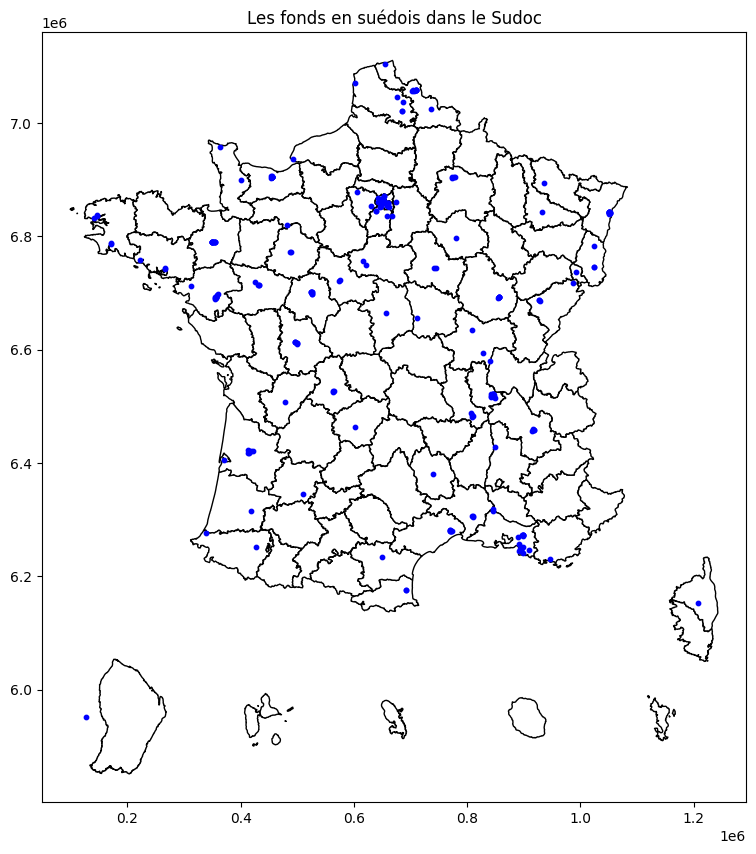

In [ ]:
fig,ax=plt.subplots(figsize=(10,10)) #On créé la figure et les axes.
x_min,y_min,x_max,y_max=fond_de_carte.total_bounds #On limite notre étendue des axes aux limites du fond de carte.
marge=50000
ax.set_xlim(x_min-marge,x_max+marge)
ax.set_ylim(y_min-marge,y_max+marge)
fond_de_carte.plot(ax=ax,color="white",edgecolor="black") #On trace le fond de carte.
gdf_swe_sudoc.plot(ax=ax, color="blue", markersize=10) #On trace les points.
ax.set_title("Les fonds en suédois dans le Sudoc")

###Carte avec pondérations tenant compte du nombre de notices

On présenter une visualisation cartographique avec des données quantitatives concernant le nombre de notices à l'aide d'une *bubblemap*


In [ ]:
df=df_swe_sudoc.copy() #Il faut d'abord réindexer le dataframe df_swe_sudoc. Pour ne pas désorganiser les données dans le df précédent en cas de plantage, on va en créer un nouveau.

In [ ]:
df.reset_index(inplace=True) #On réindexe, sinon il va y avoir un bug plus tard.
df.index = df.index + 1 #C'est mieux de faire commencer l'index par "1" quand on a affaire à un classement...
df.rename(columns={"index":"RCR"}, inplace=True) #On met le RCR en première colonne.
df

In [ ]:
gdf=gpd.GeoDataFrame(df,geometry="geometry")

In [ ]:
gdf.set_crs(epsg=4326,inplace=True)#On remouline le gdf en Lambert93 comme tout à l'heure pour qu'il corresponde au fond de carte.
gdf=gdf.to_crs(epsg=2154)
gdf=gdf.to_crs(fond_de_carte.crs)

Text(0.5, 1.0, 'Bubble map des documents en suédois dans le Sudoc')

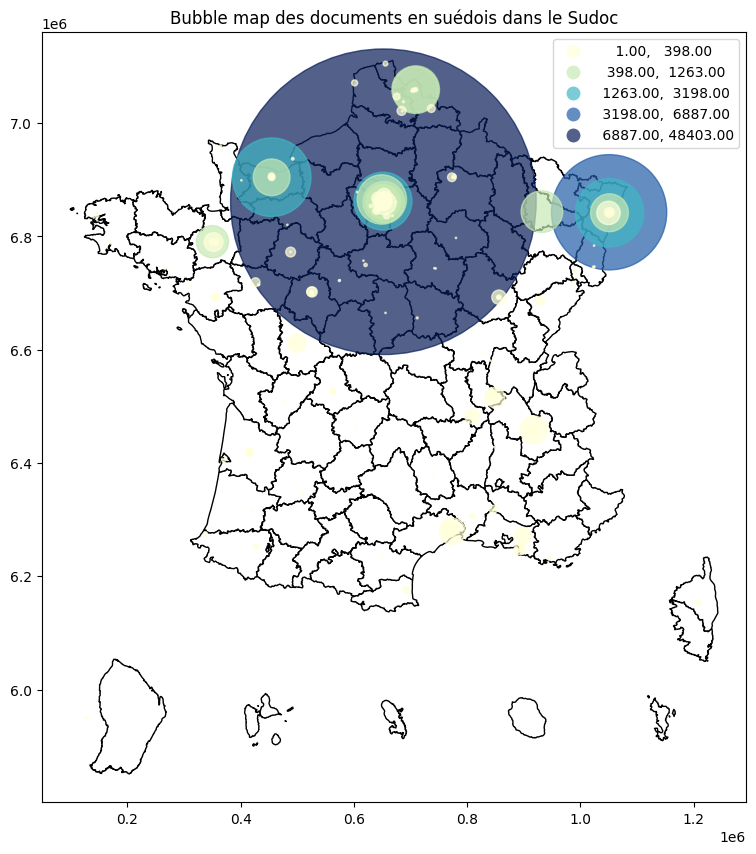

In [ ]:
fig,ax=plt.subplots(figsize=(10,10)) #Pareil que tout à l'heure.
x_min,y_min,x_max,y_max=fond_de_carte.total_bounds
marge = 50000
ax.set_xlim(x_min - marge, x_max + marge)
ax.set_ylim(y_min - marge, y_max + marge)
fond_de_carte.plot(ax=ax, color="white", edgecolor="black")

gdf.plot(ax=ax,column="Notices",cmap="YlGnBu",scheme="natural_breaks",legend=True,markersize=gdf["Notices"],alpha=0.7)  #On trace les points avec la taille basée sur la colonne "Notices". On utilise une échelle de couleurs du jaune vers le bleu, pour ressembler - une peu - au drapeau suédois.
ax.set_title("Bubble map des fonds en suédois dans le Sudoc") #On voit sur cette carte qu'une bibliothèque sur la place parisienne a des fonds en quantité beaucoup plus importante que les autres.

###Diagramme en barres des 25 premières bibliothèques posssédant des fonds en suédois en termes de nombre de notices

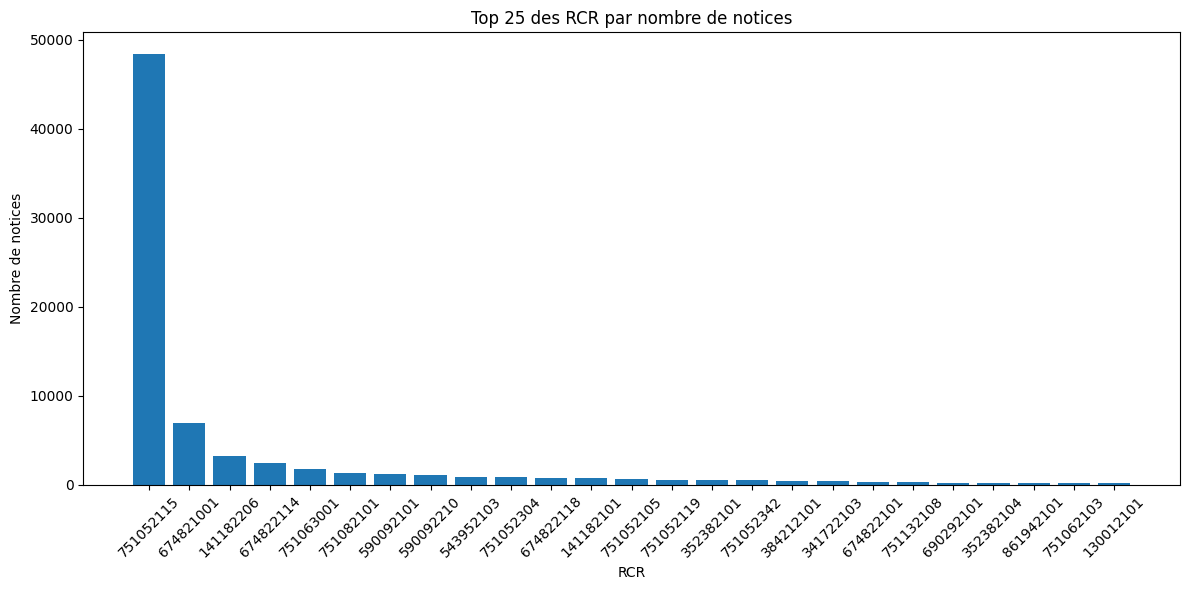

In [ ]:
df_top_25=df.sort_values("Notices",ascending=False).head(25) #On veut le top 25 du Sudoc en termes de nombres de notices.
plt.figure(figsize=(12,6))
plt.bar(df_top_25["RCR"], df_top_25["Notices"])
plt.xlabel("RCR")
plt.ylabel("Nombre de notices")
plt.title("Top 25 des RCR par nombre de notices de documents en suédois")
plt.xticks(rotation=45)
plt.tight_layout() #Effectivement, la Nordique, possédant près de 70% des fonds, est loin devant...